# Atividade 1 
Neste trabalho, você terá que entregar um notebook (preferencialmente, um link para um Colab) que implementa um auto-encoder. Para isso:

- Assista aos vídeos de Perceptron e MLP feitos só com numpy. Sua implementação deve seguir o que está lá, porém...
- Sua implementação deve permitir o usuário definir a arquitetura, ou seja, quantas camadas e quantos neurônios em cada uma delas eu vou querer usar. Explique no notebook como é o formato para eu definir isso.
- O notebook deve ter seções e textos explicativos. Ou seja, deve have uma documentação interna.
- Eu testarei com dados sintéticos, como os feitos para as aulas de Perceptron e MLP na prática. Porém, serão melhores (mais atributos, mais intersecção entre os "blobs", etc).


Grupo:

| Nome          | nUSP     |
|---------------|----------|
| Rafael Zimmer | 12542612 |
| Murilo Soave  |          |

In [1]:
from abc import ABC, abstractmethod
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Gerando o conjunto de dados:

Vamos criar um conjunto de dados sintético para testar o multi-layer perceptron.
Para a atividade, vamos definir uma estrutura que permita multiplas classes e multiplas colunas.

--------------------------------------------
### Função generate_class(mu, sigma, n)
Essa função gera dados para uma única classe com base nos parâmetros fornecidos:

* mu: a média da distribuição normal que define a classe.
* sigma: o desvio padrão da distribuição normal que define a classe.
* n: o número de observações a serem geradas.

A função numpy.random.normal() é usada para gerar os dados de acordo de uma forma estável com a distribuição normal, retornando um array com n observações.

--------------------------------------------

### Função generate_data(classes)
Essa função gera dados para várias classes, onde cada classe é definida por um conjunto de parâmetros.

* classes: um dicionário onde as chaves representam os rótulos das classes e os valores são tuplas contendo o número de observações (n) e uma lista de pares (mu, sigma) representando os parâmetros da distribuição normal para cada coluna.
A função itera sobre as classes fornecidas, gerando dados para cada uma delas usando a função generate_class(). Em seguida, concatena os dados gerados para todas as classes e adiciona codificação one-hot para os rótulos das classes. Por fim, embaralha os dados e os retorna.

Em suma, esses dois métodos servem para facilitar gerar distribuições de dados separáveis e não separáveis para testar o MLP. 

--------------------------------------------

In [2]:
def generate_class(mu, sigma, n):
    return np.random.normal(mu, sigma, n)


def generate_data(classes):
    data = []
    for label, params in classes.items():
        n, columns = params
        
        observations = []
        
        for mu, sigma in columns:
            observations.append(generate_class(mu, sigma, n))
        
        observations = np.array(observations).T
        # one hot encoding
        y_true = np.zeros((n, len(classes)))
        y_true[:, label] = 1
        
        data.append(np.concatenate([observations, y_true], axis=1))
    
    sorted_data = np.concatenate(data, axis=0)  
    
    return np.random.permutation(sorted_data)

## Visualizando o conjunto de dados

Para facilitar a visualização, vamos gerar dados com apenas 2 dimensões. Cada classe é representada por uma cor diferente.

(2000, 4)
[[ 9.79258994  0.86768722]
 [ 3.6516074  -0.37937233]
 [ 9.29850895 -1.10479485]
 [ 4.64386151  0.19788817]
 [ 9.67057269  3.76212021]] 
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


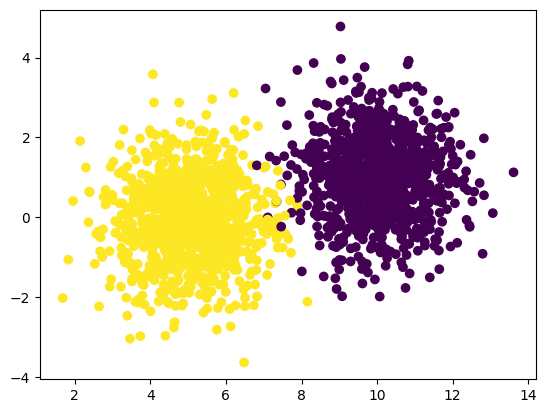

In [3]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
}

data = generate_data(classes)

# 2 classes + 2 features
print(data.shape)
print(data[:5, :2], "\n", data[:5, 2:])

labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')

## Definindo uma Loss function

Essas classes são utilizadas para definir e calcular os erros dos modelos, especificamente a Cross Entropy, comum para problemas de classificação multiclasse.

------------------------------------
### Classe CrossEntropy
Essa classe implementa a função de entropia cruzada, que parte da definição de entropia de sistemas dinâmicos, na física.

softmax(self, x): Método que calcula a função softmax de um vetor x. Isso é usado para converter as saidas de um modelo em probabilidades.

__call__(self, y_true, y_pred): Calcula a entropia cruzada entre as previsões y_pred e os rótulos verdadeiros y_true. Também guarda o valor do loss e calcula o gradiente.

gradient(self, y_true, y_pred): Utilizado para retornar o gradiente calculado.

Em suma, a cross entropy usa a função softmax internamente para converter as saidas numéricas no domínio dos reais em probabilidades e calcula a perda e o gradiente com base nessas probabilidades e nos _labels_ verdadeiros.

------------------------------------

In [4]:
class Loss(ABC):
    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass
    
    @abstractmethod
    def gradient(self, y_true, y_pred):
        pass
    
    
class CrossEntropy(Loss):
    @staticmethod
    def softmax(x):
        exps = np.exp(x - x.max())
        # non-batched implementation
        return exps / exps.sum()
    
    def __call__(self, y_true, y_pred):
        y_pred = self.softmax(y_pred)
        return -np.sum(y_true * np.log(y_pred)), y_pred
    
    def gradient(self, y_true, y_pred):
        return y_pred - y_true
    
    
class Activation(ABC):
    @abstractmethod
    def __call__(self, x):
        pass
    
    @abstractmethod
    def gradient(self, x):
        pass

class Tanh(Activation):
    def __call__(self, x):
        return np.tanh(x)
    
    def gradient(self, x):
        return 1 - np.tanh(x) ** 2

In [5]:
criterion = CrossEntropy()
y_true = np.array([[0, 1], [1, 0], [0, 1]])
y_pred = np.array([[0.1, 0.9], [0.9, 0.1], [0.2, 0.8]])

loss, y_pred = criterion(y_true, y_pred)
grad = criterion.gradient(y_true, y_pred)

print(f"Loss: {loss}")
print(f"Gradient: {grad}")

Loss: 4.47590133505587
Gradient: [[ 0.10449315 -0.76744622]
 [-0.76744622  0.10449315]
 [ 0.11548279 -0.78957664]]


In [6]:
tan = Tanh()
x = np.array([0, 1, 2, 3])
print(f"x, tanh(x): {x} -> {tan(x)}")

x, tanh(x): [0 1 2 3] -> [0.         0.76159416 0.96402758 0.99505475]


## Implementando o MLP em si

Classe MLP (_Multi-Layer Perceptron_):

* __init__(self, layers): O construtor inicializa os parâmetros da rede neural com base nas camadas fornecidas. _layers é uma lista que especifica o número de neurônios em cada camada.
* forward(self, x): Realiza a operação de feedforward na rede neural, aplicando a função de ativação camada à camada. É em essência um loop de produtos matriciais com pesos e passe das ativações (tornando o modelo não linear).
* backward(self, grad, lr=0.01): Faz o _backpropagation_ do gradiente na rede neural, atualizando os pesos e os viéses com base no gradiente descendente estocástico (SGD). (O valor grad é o gradiente da função de _loss_ em relação à saída da rede neural).
* pred(self, x=None, value=None): Retorna o y_hat da rede neural com base nas entradas fornecidas x ou em valores value.

Essa classe é uma implementação simples do que será utilizado para um exemplo de Autoencoder no final, com hidden layers não simétricas.

Output shape: (4,)
[[-1.39754099 -1.14114798  0.1566178   2.06777843 -0.82839938  0.86890163
   0.39625774 -0.35687086 -0.64648488  1.84729687]
 [-1.34104615 -0.97501732  1.09257403  0.55047764 -1.90517134  0.619116
  -0.74992265  0.53662182 -0.21883974  1.09407711]]


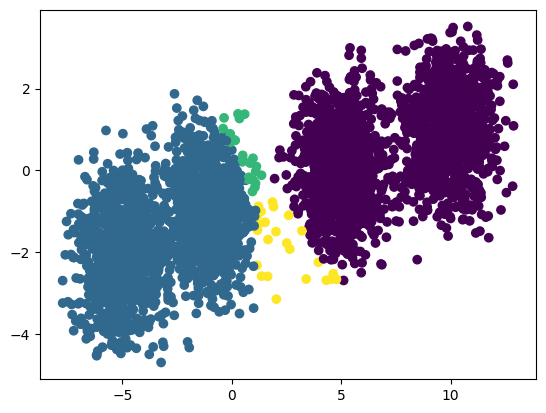

In [160]:
class Module(ABC):
    def __init__(self):
        pass
    
    def __call__(self, x):
        return self.forward(x)
    
    def weights(self):
        return self.weights
    
    def pred(self, x=None, value=None):
        def _to_class(y):
            return np.argmax(y, axis=1)
        if value is not None:
            return _to_class(value)
        elif x is not None:
            return _to_class(self.forward(x))
        else:
            raise ValueError('x or value must be provided')
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, grad, lr=0.01):
        pass


class MLP(Module):
    def __init__(self, layers, activations: List[Activation]):
        super().__init__()
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []
        self._z = []  # Intermediate values
        
        self.velocity_weights = [0] * (len(layers) - 1)
        self.velocity_biases = [0] * (len(layers) - 1)
        
        for i in range(1, len(layers)):
            self.weights.append(np.random.randn(layers[i-1], layers[i]))
            self.biases.append(np.random.randn(layers[i]))
            self._z.append(np.zeros(layers[i]))
        self._z.append(np.zeros(layers[-1]))
    
    def forward(self, x):
        self._z[0] = (x, None)
        y = x
        for i, (w, b, activation) in enumerate(zip(self.weights, self.biases, self.activations)):
            # calculate weights * x + bias
            x = x @ w + b
            y = activation(x)
            self._z[i+1] = (x, y)
        
        return y

    def backward(self, grad, lr=0.01, momentum=0.9, noise_scale=0.001):
        for i in range(len(self.weights) - 1, -1, -1):
            x, y = self._z[i + 1]
            activation = self.activations[i]

            grad = grad * activation.gradient(x)
            grad_w = y.T @ grad
            grad_b = grad.sum(axis=0)

            w = self.weights[i]
            grad = grad @ w.T

            # Introduce noise in the updates
            noise_w = np.random.randn(*grad_w.shape) * noise_scale
            noise_b = np.random.randn(*grad_b.shape) * noise_scale

            # Update velocity terms with momentum
            self.velocity_weights[i] = momentum * self.velocity_weights[i] + (1 - momentum) * (grad_w + noise_w)
            self.velocity_biases[i] = momentum * self.velocity_biases[i] + (1 - momentum) * (grad_b + noise_b)

            # Update weights and biases
            self.weights[i] -= lr * self.velocity_weights[i]
            self.biases[i] -= lr * self.velocity_biases[i]

        return grad

classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
    2: (1000, [(-1, 1), (-1, 1)]),
    3: (1000, [(-5, 1), (-2, 1)]),
}

data = generate_data(classes)
dataset = [(x[:2], x[2:]) for x in data]

mlp = MLP([
    2,  # input layer
    10,  # hidden layer
    4,  # output layer
], activations=[Tanh(), Tanh()])

forward = mlp.forward(data[0, :2])
print(f"Output shape: {forward.shape}")
print(mlp.weights[0])
plt.scatter(data[:, 0], data[:, 1], c=mlp.pred(data[:, :2]))

In [161]:
# Testing single backpropagation
criteria = CrossEntropy()
x, y = dataset[0]
y_pred = mlp.forward(x)

grad = criteria.gradient(y, y_pred)

mlp.backward(grad, lr=1e-1)
weights = mlp.weights
print(f"Weights: {weights[0]}")

Weights: [[-1.39648368 -1.14009067  0.15767511  2.06883574 -0.82734207  0.86995894
   0.39731505 -0.35581355 -0.64542757  1.84835419]
 [-1.33998884 -0.97396001  1.09363134  0.55153495 -1.90411403  0.62017331
  -0.74886534  0.53767913 -0.21778243  1.09513442]]


## Treinando o modelo

A função train(dataset, model, criterion, lr=1e-4, epochs=1000) é responsável por treinar o modelo de acordo com os dados fornecidos.
O treinamento é feito por meio de um loop de épocas, onde cada época é composta por um loop de iterações sobre o conjunto de dados, mas é importante notar que o grosso da implementação está no método backward da classe MLP (que é um SGD padrão).

In [162]:
def train(dataset, model: Module, criterion: Loss, lr, epochs=1000):
    losses = [+np.inf]
    
    # Turn on interactive mode
    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    
    # Loop over epochs
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_true = 0
        
        # For each epoch, iterate over the dataset and update the weights
        for x, y in dataset:
            
            y_pred = model(x)
            loss, y_pred = criterion(y, y_pred)
            grad = criterion.gradient(y, y_pred)
            
            model.backward(grad, lr=lr)
            
            epoch_loss += loss
            
            label_pred = np.argmax(y_pred)
            label_true = np.argmax(y)
            epoch_true += int(label_pred == label_true)
        
        epoch_acc = epoch_true / len(dataset)
        
        if epoch % 50 == 0:
            losses.append(epoch_loss)
            print(f'Epoch {epoch} - Loss: {epoch_loss}', f', Accuracy: {epoch_acc}')
            
            ax.plot(losses[1:], '-o', color='b')
            fig.canvas.draw()
            fig.canvas.flush_events()
            
        if np.abs(epoch_loss) < 1e-3 or np.isnan(epoch_loss) or np.abs(losses[-1] - losses[-2]) < 1e-6:
            break
            
    return losses

Loss: 126.07452891182183


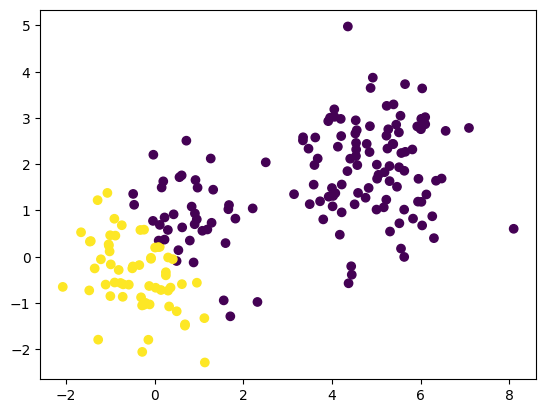

In [167]:
classes = {
    0: (100, [(5, 1), (2, 1)]),
    1: (100, [(0, 1), (0, 1)]),
}

data = generate_data(classes)
dataset = [(x[:2], x[2:]) for x in data]

mlp = MLP([
    2,  # input layer
    10,  # hidden layer
    2,  # output layer
], activations=[Tanh(), Tanh(), Tanh(), Tanh()])

criteria = CrossEntropy()
print(f"Loss: {np.sum([criteria(y, mlp(x))[0] for x, y in dataset])}")
plt.scatter(data[:, 0], data[:, 1], c=mlp.pred(data[:, :2]))

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0 - Loss: 125.85303850286849 , Accuracy: 0.805
Epoch 50 - Loss: 114.06180060690038 , Accuracy: 0.875
Epoch 100 - Loss: 110.62767387839942 , Accuracy: 0.895
Epoch 150 - Loss: 109.13272350114342 , Accuracy: 0.92
Epoch 200 - Loss: 107.8513598665156 , Accuracy: 0.935
Epoch 250 - Loss: 106.45167150311735 , Accuracy: 0.98
Epoch 300 - Loss: 104.60652868205621 , Accuracy: 0.93
Epoch 350 - Loss: 102.57652319220955 , Accuracy: 0.9
Epoch 400 - Loss: 100.22323012925288 , Accuracy: 0.885
Epoch 450 - Loss: 96.13200378839296 , Accuracy: 0.81
Epoch 500 - Loss: 91.96247566327204 , Accuracy: 0.715
Epoch 550 - Loss: 88.84854759921987 , Accuracy: 0.69
Epoch 600 - Loss: 87.49665181485796 , Accuracy: 0.68
Epoch 650 - Loss: 87.05277739038011 , Accuracy: 0.7
Epoch 700 - Loss: 86.60004974489367 , Accuracy: 0.71
Epoch 750 - Loss: 85.11829970470592 , Accuracy: 0.7
Epoch 800 - Loss: 84.32198881247335 , Accuracy: 0.685
Epoch 850 - Loss: 84.19954141626316 , Accuracy: 0.705
Epoch 900 - Loss: 84.17411426322286 

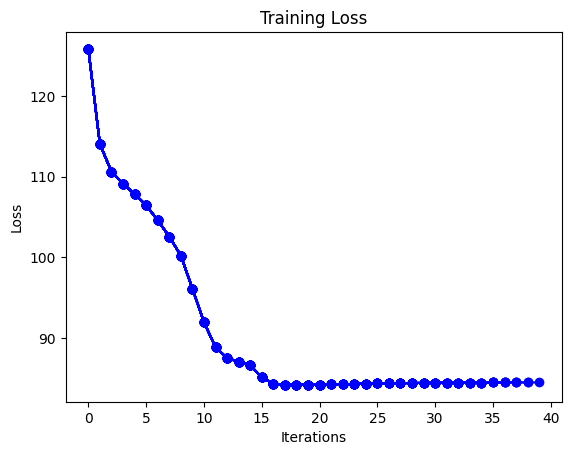

In [168]:
losses = train(dataset, mlp, criterion, lr=1e-3, epochs=2000)

Loss: 84.4868403042442


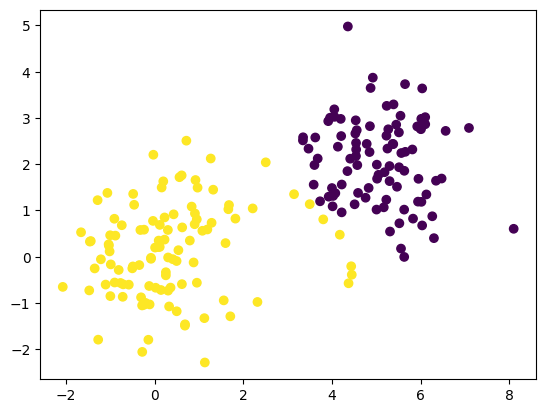

In [169]:
print(f"Loss: {np.sum([criteria(y, mlp(x))[0] for x, y in dataset])}")
plt.scatter(data[:, 0], data[:, 1], c=mlp.pred(data[:, :2]))

In [170]:
class Autoencoder(Module):
    def __init__(self, encoder_layers, decoder_layers):
        super().__init__()
        
        encoder = MLP(encoder_layers, activations=[Tanh() for _ in encoder_layers[1:]])
        decoder = MLP(decoder_layers, activations=[Tanh() for _ in decoder_layers[1:]])
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def backward(self, grad, lr=0.01):
        grad = self.decoder.backward(grad, lr=lr)
        return self.encoder.backward(grad, lr=lr)
        

(400, 6)


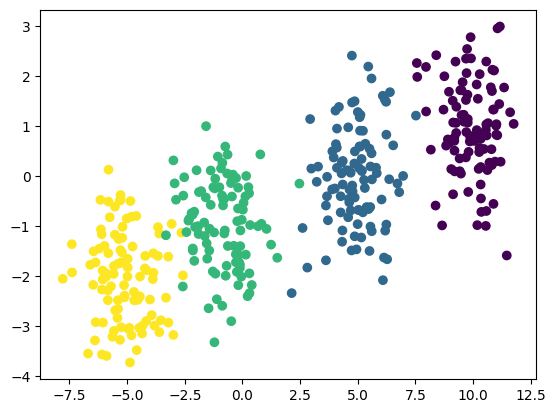

In [196]:
# 2 features, 4 classes
classes = {
    0: (100, [(10, 1), (1, 1)]),
    1: (100, [(5, 1), (0, 1)]),
    2: (100, [(-1, 1), (-1, 1)]),
    3: (100, [(-5, 1), (-2, 1)]),
}
data = generate_data(classes)

dataset = [(x[:2], x[2:]) for x in data]

print(data.shape)
plt.scatter(data[:, 0], data[:, 1], c=np.argmax(data[:, 2:], axis=1))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 - Loss: 644.5180452023951 , Accuracy: 0.5
Epoch 50 - Loss: 579.8352706598478 , Accuracy: 0.5
Epoch 100 - Loss: 540.0818828796683 , Accuracy: 0.5
Epoch 150 - Loss: 530.0161779110556 , Accuracy: 0.5
Epoch 200 - Loss: 529.4200130487272 , Accuracy: 0.5
Epoch 250 - Loss: 528.7206009507987 , Accuracy: 0.5
Epoch 300 - Loss: 526.2398903608944 , Accuracy: 0.4975
Epoch 350 - Loss: 522.4230667848053 , Accuracy: 0.4975
Epoch 400 - Loss: 517.7154197235407 , Accuracy: 0.4975
Epoch 450 - Loss: 512.5180306331544 , Accuracy: 0.4975
Epoch 500 - Loss: 507.29263805304254 , Accuracy: 0.495
Epoch 550 - Loss: 502.7276337321758 , Accuracy: 0.495
Epoch 600 - Loss: 499.8300642525624 , Accuracy: 0.495
Epoch 650 - Loss: 498.86868201562584 , Accuracy: 0.495
Epoch 700 - Loss: 498.75730371835317 , Accuracy: 0.495
Epoch 750 - Loss: 498.7472501832405 , Accuracy: 0.495
Epoch 800 - Loss: 498.72177351017905 , Accuracy: 0.495
Epoch 850 - Loss: 498.686139683023 , Accuracy: 0.495
Epoch 900 - Loss: 498.6532408235088 

[inf,
 644.5180452023951,
 579.8352706598478,
 540.0818828796683,
 530.0161779110556,
 529.4200130487272,
 528.7206009507987,
 526.2398903608944,
 522.4230667848053,
 517.7154197235407,
 512.5180306331544,
 507.29263805304254,
 502.7276337321758,
 499.8300642525624,
 498.86868201562584,
 498.75730371835317,
 498.7472501832405,
 498.72177351017905,
 498.686139683023,
 498.6532408235088,
 498.6163778911096]

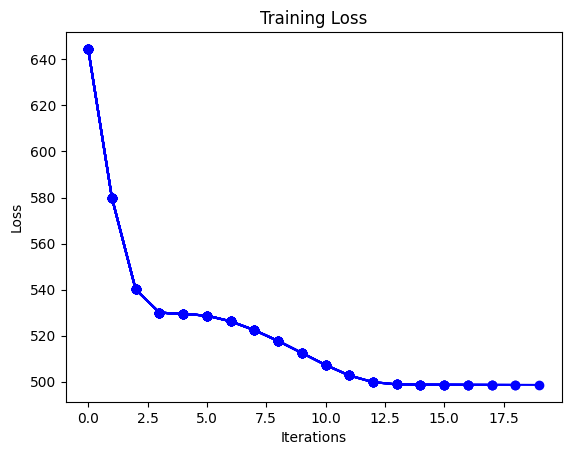

In [200]:
autoencoder = Autoencoder(
    encoder_layers=[2, 4, 3],
    decoder_layers=[3, 3, 4],
)

lr = 1e-4

train(dataset, autoencoder, criterion, lr=lr, epochs=1000)

Loss: 498.56517491623293
Accuracy: 0.495


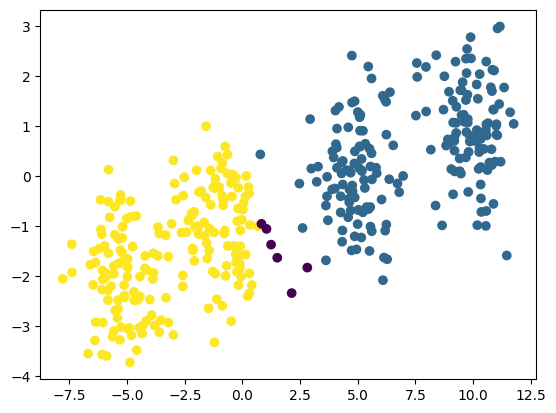

In [201]:
print(f"Loss: {np.sum([criteria(y, autoencoder(x))[0] for x, y in dataset])}")
print(f"Accuracy: {np.mean([np.argmax(y) == np.argmax(autoencoder(x)) for x, y in dataset])}")
plt.scatter(data[:, 0], data[:, 1], c=autoencoder.pred(data[:, :2]))